<a href="https://colab.research.google.com/github/rendrasatriar/Density-SILO/blob/Bintangor/Bintangor_LIMX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [ ]:
!pip install --quiet google-cloud-bigquery pandas pyarrow

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import bigquery
import pandas as pd

PROJECT_ID = "study-density-silo"
DATASET_ID = "study_density"
TABLE_ID = "raw_data_bintangor"

client = bigquery.Client(project=PROJECT_ID)

def fetch_single_block(project: str, dataset: str, table_id: str, max_rows: int = None) -> pd.DataFrame:
    table_full = f"{project}.{dataset}.{table_id}"
    query = f"SELECT * FROM `{table_full}`"
    job = client.query(query)
    if max_rows:
        return job.result(max_results=max_rows).to_dataframe()
    return job.to_dataframe()

In [4]:
# --- Ambil data satu blok ---
df_block = fetch_single_block(PROJECT_ID, DATASET_ID, TABLE_ID)
print(f"Loaded table: {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}")
print("Rows:", len(df_block))
print("Columns:", len(df_block.columns))
print("Shape:", df_block.shape)
print("-" * 60)

# --- Informasi kolom dan tipe data ---
print("\nColumn info:")
print(df_block.dtypes)
print("\nMemory usage (MB):")
print(df_block.memory_usage(deep=True).sum() / 1024**2)

# --- Statistik numerik singkat ---
print("\nDescriptive statistics (numeric columns):")
display(df_block.describe().transpose())

# --- Distribusi kategori penting ---
if 'GEN_LYR' in df_block.columns:
    print("\nUnique GEN_LYR count:", df_block['GEN_LYR'].nunique())
    print("Top GEN_LYR value counts:")
    display(df_block['GEN_LYR'].value_counts().head(20))

if 'Material' in df_block.columns:
    print("\nUnique Material count:", df_block['Material'].nunique())
    print("Top Material value counts:")
    display(df_block['Material'].value_counts().head(20))

# --- Quick QAQC checks ---
print("\nQAQC checks:")
if {'Interval','From','To'}.issubset(df_block.columns):
    n_bad_interval = len(df_block[(df_block['Interval'] <= 0) | (df_block['To'] <= df_block['From'])])
    print("Rows with Interval <= 0 or To <= From:", n_bad_interval)
else:
    print("Columns Interval/From/To not all present for QAQC checks.")

Loaded table: study-density-silo.study_density.raw_data_bintangor
Rows: 11548
Columns: 16
Shape: (11548, 16)
------------------------------------------------------------

Column info:
HoleId         object
Hill           object
Hill_Group     object
From          float64
To            float64
Interval      float64
CoreRec       float64
WetW          float64
H2O           float64
DryW          float64
Material       object
Layer          object
NEW_LYR        object
GEN_LYR        object
WTF           float64
DTF           float64
dtype: object

Memory usage (MB):
4.864101409912109

Descriptive statistics (numeric columns):


,count,mean,std,min,25%,50%,75%,max
From,11548.0,5.680615,3.949815,0.000000,2.600000,5.075000,8.000000,23.000000
To,11548.0,6.448785,3.934414,0.200000,3.000000,6.000000,9.000000,23.900000
Interval,11548.0,0.768170,0.290259,0.050000,0.500000,1.000000,1.000000,3.000000
CoreRec,11548.0,1.081167,0.188022,0.200000,1.000000,1.000000,1.090000,3.500000
WetW,11548.0,4.179988,1.862441,0.400000,2.640000,4.259500,5.515000,13.340000
H2O,11548.0,25.032835,14.841084,0.079000,12.402250,25.364500,36.083250,90.147000
DryW,11548.0,3.181767,1.628951,0.156000,1.835000,3.057500,4.336000,11.840000
WTF,11548.0,1.756388,0.571895,0.195304,1.489770,1.723069,1.953043,23.925631
DTF,11548.0,1.335409,0.587918,0.123134,0.992927,1.266640,1.612504,22.471965



Unique GEN_LYR count: 5
Top GEN_LYR value counts:


,count
GEN_LYR,
LIM,5803
BRK,2925
SAP,2291
SAPX,312
LIMX,217



Unique Material count: 50
Top Material value counts:


,count
Material,
YLIM,2423
Rlim,1583
ESAP,1572
HGT,933
HSAP,882
RSAP,831
Sap,700
RLIM,380
DNT,365



QAQC checks:
Rows with Interval <= 0 or To <= From: 0


# Filter By GEN_LYR

In [65]:
gen_lyr_input = input("Masukkan GEN_LYR yang ingin difilter: ").strip()

# Input beberapa material, pisahkan dengan koma
materials_input = input("Masukkan Material yang ingin difilter (pisahkan dengan koma): ").strip()
materials_list = [m.strip().upper() for m in materials_input.split(",")]

df_filtered = df_block.copy()

# Filter GEN_LYR
if 'GEN_LYR' in df_filtered.columns:
    df_filtered = df_filtered[df_filtered['GEN_LYR'].str.upper() == gen_lyr_input.upper()]

# Filter Material (lebih dari satu)
if 'Material' in df_filtered.columns and len(materials_list) > 0:
    df_filtered = df_filtered[df_filtered['Material'].str.upper().isin(materials_list)]

print(f"\nFiltered rows: {len(df_filtered)}")
display(df_filtered.head(133))

Masukkan GEN_LYR yang ingin difilter: LIMX
Masukkan Material yang ingin difilter (pisahkan dengan koma): GRAV_3,BS_1,GRAV_1,GRAV_2,YS_1,YS_2,YS_3,YS_4,GRAV_5,GRAV_4,BS_2,BS_3,LIM,YLIM,RLIM,IRC,Rlimx,Esap,Sap

Filtered rows: 209


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
23,CS7210246,Bintangor Blok 1 Spasi 50,BINTANGOR,0.00,1.00,1.00,1.00,5.220,26.628,3.830,Rlim,None,LIM,LIMX,1.785444,1.310010
43,CD02484,BINTANGOR BARAT SELATAN,BINTANGOR,0.00,0.30,0.30,1.00,0.686,7.818,0.632,BS_1,None,LIM,LIMX,0.782129,0.720986
48,CS7210248,Bintangor Blok 1 Spasi 50,BINTANGOR,0.00,0.75,0.75,1.20,5.280,30.492,3.670,Rlim,None,LIM,LIMX,2.006629,1.394759
59,CS6210193,Bintangor Blok 2 Spasi 25,BINTANGOR,0.00,1.00,1.00,1.00,5.251,17.882,4.312,Rlim,None,LIM,LIMX,1.796047,1.474872
89,CS6210152R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.00,1.00,1.00,1.00,4.775,22.869,3.683,Rlim,None,LIM,LIMX,1.633236,1.259730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3690,CS7210248,Bintangor Blok 1 Spasi 50,BINTANGOR,3.00,3.85,0.85,1.17,4.140,47.343,2.180,ESAP,None,SAP,LIMX,1.423873,0.749769
3755,CS6210002R,Bintangor Blok 2 Spasi 25,BINTANGOR,3.28,3.50,0.22,1.42,2.294,16.303,1.920,Rlim,None,LIM,LIMX,2.511644,2.102161
3848,CS6210055,Bintangor Blok 2 Spasi 25,BINTANGOR,3.50,4.00,0.50,1.70,4.790,16.472,4.001,YLIM,None,LIM,LIMX,1.927491,1.609998
3852,CS6210054,Bintangor Blok 2 Spasi 25,BINTANGOR,3.50,4.00,0.50,1.37,4.488,16.756,3.736,Rlim,None,LIM,LIMX,2.240980,1.865486


# Filter By Interval

Descriptive statistics for Interval:
Count: 209
Mean: 0.834306
Standard Error: 0.018080
Median: 1.0
Mode: 1.0
Standard Deviation: 0.261373
Sample Variance: 0.068316
Kurtosis: -0.239737
Skewness: -1.047215
Range: 1.23
Minimum: 0.17
Maximum: 1.4
Sum: 174.37
Confidence Level (95%): ±0.035643

Bin calculation:
Freedman–Diaconis -> bins: 10, bin width: 0.134806
Sturges -> bins: 9, bin width: 0.136667


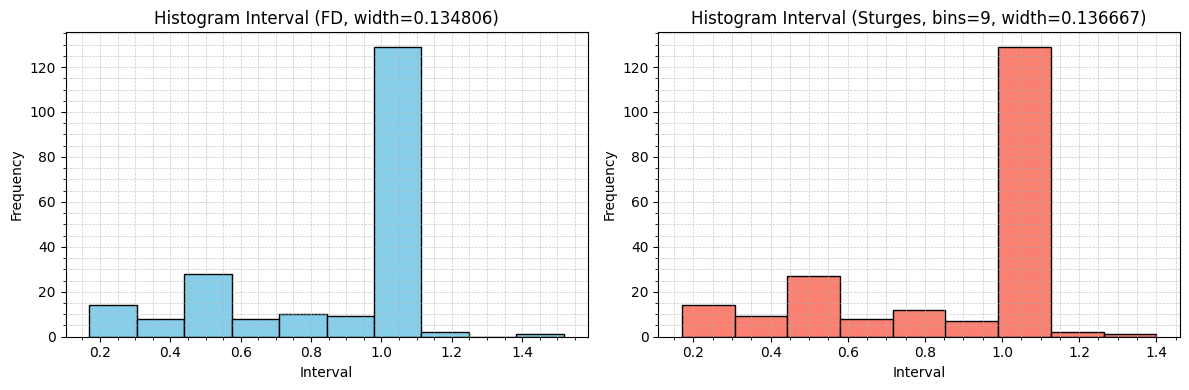


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.170000,0.304806,14
1,0.304806,0.439611,8
2,0.439611,0.574417,28
3,0.574417,0.709222,8
4,0.709222,0.844028,10
5,0.844028,0.978834,9
6,0.978834,1.113639,129
7,1.113639,1.248445,2
8,1.248445,1.383250,0
9,1.383250,1.518056,1



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.170000,0.306667,14
1,0.306667,0.443333,9
2,0.443333,0.580000,27
3,0.580000,0.716667,8
4,0.716667,0.853333,12
5,0.853333,0.990000,7
6,0.990000,1.126667,129
7,1.126667,1.263333,2
8,1.263333,1.400000,1


In [66]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return int(np.sqrt(n)), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series):
    data = series.dropna().values
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    se = stats.sem(data)
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0] if n > 0 else None
    var = np.var(data, ddof=1)
    kurt = stats.kurtosis(data)
    skew = stats.skew(data)
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else None

    print("Descriptive statistics for Interval:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}")
    print(f"Sample Variance: {var:.6f}")
    print(f"Kurtosis: {kurt:.6f}")
    print(f"Skewness: {skew:.6f}")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): \u00b1{conf95:.6f}")

def plot_interval_histograms(df_filtered):
    if 'Interval' not in df_filtered.columns:
        print("Kolom 'Interval' tidak ada di dataframe.")
        return

    data = df_filtered['Interval'].dropna()

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data)

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins: {bins_fd}, bin width: {width_fd_str}")
    print(f"Sturges -> bins: {bins_st}, bin width: {width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram Interval (FD, width={width_fd_str})")
    axes[0].set_xlabel("Interval")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram Interval (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("Interval")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
interval_data = plot_interval_histograms(df_filtered) # Corrected function call

In [67]:
# Pastikan df_filtered sudah ada
# Contoh: df_filtered = filter_data(df_block, "LIM", "RLIM")

# Minta input dari user
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))

# Filter data sesuai input
df_interval = df_filtered[(df_filtered['Interval'] >= lower_bound) &
                       (df_filtered['Interval'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_interval)}")
display(df_interval.head(50))

Masukkan batas bawah (is greater than or equal to): 0.978834
Masukkan batas atas (is less than or equal to): 1.113639

Filtered rows: 129


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
23,CS7210246,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.00,5.220,26.628,3.830,Rlim,None,LIM,LIMX,1.785444,1.310010
59,CS6210193,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.00,5.251,17.882,4.312,Rlim,None,LIM,LIMX,1.796047,1.474872
89,CS6210152R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.00,4.775,22.869,3.683,Rlim,None,LIM,LIMX,1.633236,1.259730
102,CD02502,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.00,3.884,20.174,3.100,BS_1,None,LIM,LIMX,1.328480,1.060478
111,CS7210094,Bintangor Blok 2 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.00,3.516,29.465,2.480,Rlim,None,LIM,LIMX,1.202609,0.848257
117,CS6210190,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.00,3.915,16.526,3.268,Rlim,None,LIM,LIMX,1.339083,1.117784
150,CD02509,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.00,4.055,14.681,3.460,BS_1,None,LIM,LIMX,1.386968,1.183341
237,CS6210191,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.00,3.250,19.785,2.607,Rlim,None,LIM,LIMX,1.111627,0.891696
254,CS6210030,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.00,3.868,25.336,2.888,Rlim,None,LIM,LIMX,1.323007,0.987809
260,CS6210139,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.00,4.754,15.145,4.034,Rlim,None,LIM,LIMX,1.626054,1.379785


# Filter By Recovery


Descriptive statistics for CoreRec:
Count: 129
Mean: 1.075581
Standard Error: 0.012824
Median: 1.0
Mode: 1.0
Standard Deviation: 0.145655
Sample Variance: 0.021215
Kurtosis: 1.384849
Skewness: 1.473810
Range: 0.75
Minimum: 0.8
Maximum: 1.55
Sum: 138.75
Confidence Level (95%): ±0.025375

Bin calculation:
Freedman–Diaconis -> bins=19, width=0.039582
Sturges -> bins=9, width=0.083333


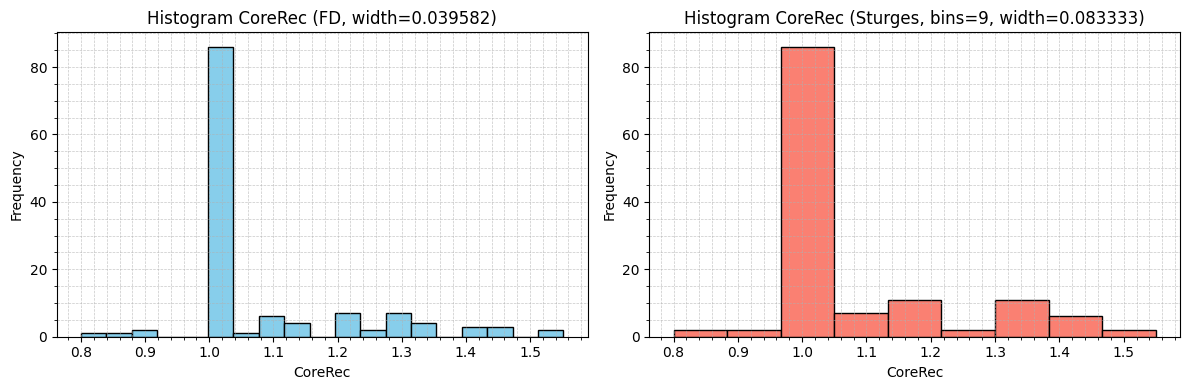


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.800000,0.839582,1
1,0.839582,0.879164,1
2,0.879164,0.918747,2
3,0.918747,0.958329,0
4,0.958329,0.997911,0
5,0.997911,1.037493,86
6,1.037493,1.077076,1
7,1.077076,1.116658,6
8,1.116658,1.156240,4
9,1.156240,1.195822,0



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.800000,0.883333,2
1,0.883333,0.966667,2
2,0.966667,1.050000,86
3,1.050000,1.133333,7
4,1.133333,1.216667,11
5,1.216667,1.300000,2
6,1.300000,1.383333,11
7,1.383333,1.466667,6
8,1.466667,1.550000,2


In [69]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="CoreRec"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_coreRec(df_interval):
    if 'CoreRec' not in df_interval.columns:
        print("Kolom 'CoreRec' tidak ada di dataframe.")
        return

    data = df_interval['CoreRec'].dropna()
    if data.empty:
        print("Tidak ada data 'CoreRec' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="CoreRec")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram CoreRec (FD, width={width_fd_str})")
    axes[0].set_xlabel("CoreRec")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram CoreRec (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("CoreRec")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
coreRec_data = analyze_coreRec(df_interval)

In [70]:
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))


df_recovery = df_interval[(df_interval['CoreRec'] >= lower_bound) &
                       (df_interval['CoreRec'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_recovery)}")
display(df_recovery.head(47))

Masukkan batas bawah (is greater than or equal to): 0.997911
Masukkan batas atas (is less than or equal to): 1.037493

Filtered rows: 86


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
23,CS7210246,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,5.220,26.628,3.830,Rlim,None,LIM,LIMX,1.785444,1.310010
59,CS6210193,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,5.251,17.882,4.312,Rlim,None,LIM,LIMX,1.796047,1.474872
89,CS6210152R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,4.775,22.869,3.683,Rlim,None,LIM,LIMX,1.633236,1.259730
102,CD02502,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.0,3.884,20.174,3.100,BS_1,None,LIM,LIMX,1.328480,1.060478
111,CS7210094,Bintangor Blok 2 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,3.516,29.465,2.480,Rlim,None,LIM,LIMX,1.202609,0.848257
117,CS6210190,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,3.915,16.526,3.268,Rlim,None,LIM,LIMX,1.339083,1.117784
150,CD02509,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.0,4.055,14.681,3.460,BS_1,None,LIM,LIMX,1.386968,1.183341
237,CS6210191,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,3.250,19.785,2.607,Rlim,None,LIM,LIMX,1.111627,0.891696
254,CS6210030,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,3.868,25.336,2.888,Rlim,None,LIM,LIMX,1.323007,0.987809
260,CS6210139,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,4.754,15.145,4.034,Rlim,None,LIM,LIMX,1.626054,1.379785


# Filter By Wet Weight


Residual IQR acuan:
Q1: -0.506, Q3: 0.558, IQR: 1.064
Lower margin: -2.102, Upper margin: 2.154


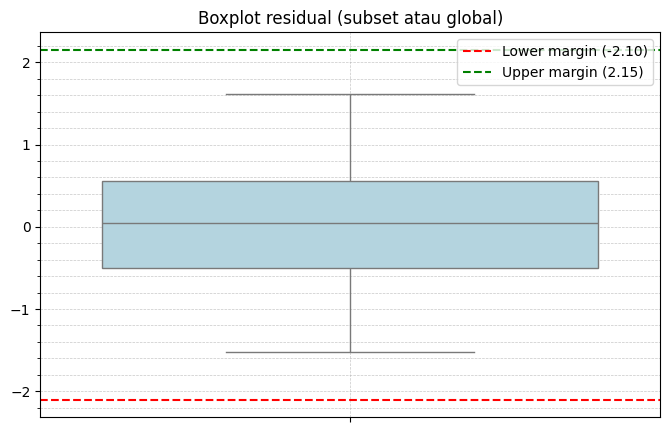

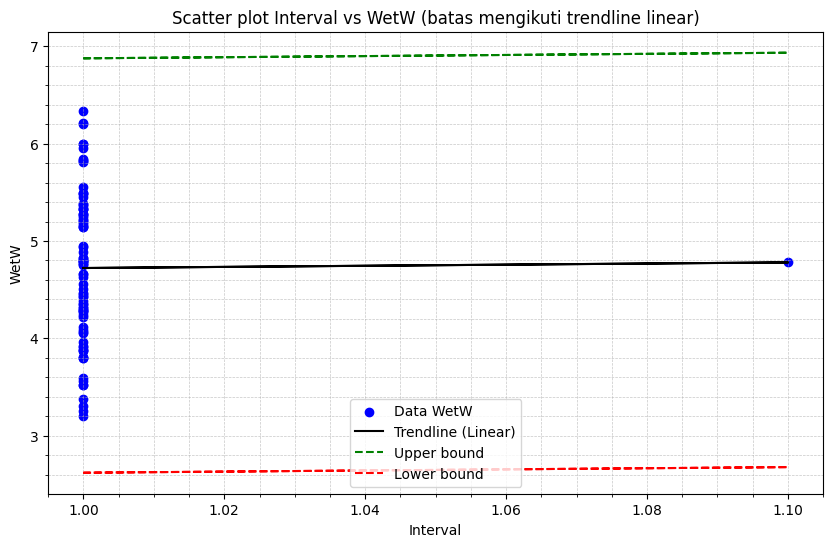


Outlier WetW berdasarkan trendline linear + IQR residual acuan:
Empty DataFrame
Columns: [HoleId, Hill, Hill_Group, From, To, Interval, CoreRec, WetW, H2O, DryW, Material, Layer, NEW_LYR, GEN_LYR, WTF, DTF]
Index: []


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['WetW'], color='blue', label='Data WetW')
    plt.plot(df_recovery['Interval'], y_pred, color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], y_pred + upper_margin, color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], y_pred + lower_margin, color='red', linestyle='--', label='Lower bound')

    # Outlier = data di luar batas trendline ± margin
    outliers = df_recovery[(df_recovery['WetW'] > y_pred + upper_margin) |
                           (df_recovery['WetW'] < y_pred + lower_margin)]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("WetW")
    plt.legend()
    plt.show()

    return {
        "outliers": outliers,
        "margins": {"lower": lower_margin, "upper": upper_margin},
        "trendline_coef": {"slope": model.coef_[0], "intercept": model.intercept_}
    }

# --- Contoh pemanggilan ---
result = detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
if result:
    print("\nOutlier WetW berdasarkan trendline linear + IQR residual acuan:")
    print(result["outliers"].head())

## Normalisasi Weight terhadap recovery

In [72]:
import numpy as np
from IPython.display import display

def normalize_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns or 'CoreRec' not in df_recovery.columns:
        print("Kolom 'WetW' atau 'CoreRec' tidak ada di dataframe.")
        return df_recovery

    # Buat kolom baru Normalized_WetW
    df_recovery['Normalized_WetW'] = np.where(
        df_recovery['CoreRec'] > 1.0,
        df_recovery['WetW'] / 1,          # jika CoreRec > 1.0
        df_recovery['WetW'] / df_recovery['CoreRec']  # jika CoreRec <= 1.0
    )

    print("\nNormalisasi WetW terhadap Recovery selesai.")
    # tampilkan seluruh dataframe dengan kolom tambahan
    display(df_recovery)

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = normalize_wetw(df_recovery)


Normalisasi WetW terhadap Recovery selesai.


/tmp/ipython-input-7809237.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Normalized_WetW'] = np.where(


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW
23,CS7210246,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,5.220,26.628,3.830,Rlim,None,LIM,LIMX,1.785444,1.310010,5.220
59,CS6210193,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,5.251,17.882,4.312,Rlim,None,LIM,LIMX,1.796047,1.474872,5.251
89,CS6210152R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,4.775,22.869,3.683,Rlim,None,LIM,LIMX,1.633236,1.259730,4.775
102,CD02502,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.0,3.884,20.174,3.100,BS_1,None,LIM,LIMX,1.328480,1.060478,3.884
111,CS7210094,Bintangor Blok 2 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,3.516,29.465,2.480,Rlim,None,LIM,LIMX,1.202609,0.848257,3.516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5502,CD500152,BINTANGOR BARAT SELATAN,BINTANGOR,5.0,6.0,1.0,1.0,5.139,6.305,4.815,IRC,None,LIM,LIMX,1.757739,1.646918,5.139
5560,CS6210190,Bintangor Blok 2 Spasi 25,BINTANGOR,5.0,6.0,1.0,1.0,4.090,35.795,2.626,YLIM,None,LIM,LIMX,1.398940,0.898195,4.090
5628,CS7210105,Bintangor Blok 2 Spasi 50,BINTANGOR,5.0,6.0,1.0,1.0,3.800,33.526,2.526,YLIM,None,LIM,LIMX,1.299748,0.863991,3.800
6226,CS6210169,Bintangor Blok 2 Spasi 25,BINTANGOR,5.9,7.0,1.1,1.0,4.780,43.033,2.723,YLIM,None,SAP,LIMX,1.486315,0.846702,4.780



Residual IQR acuan:
Q1: -0.506, Q3: 0.558, IQR: 1.064
Lower margin: -2.102, Upper margin: 2.154


/tmp/ipython-input-1577443899.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
/tmp/ipython-input-1577443899.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Outlier_Status'] = [


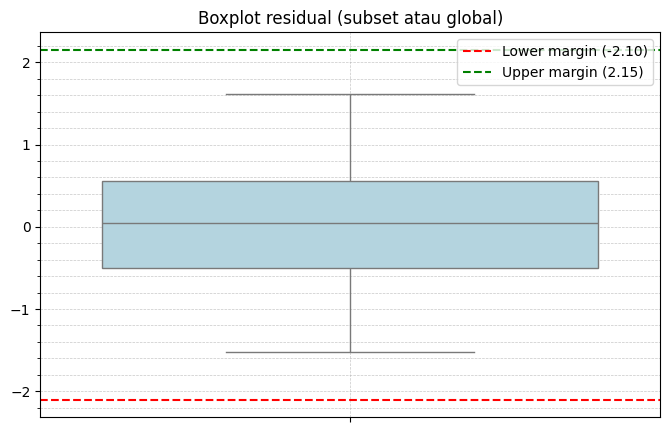

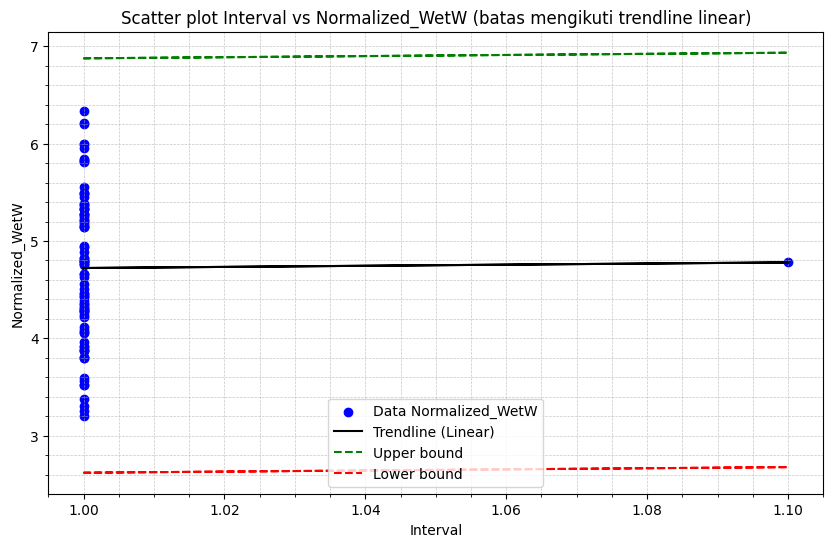

,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred,Outlier_Status
23,CS7210246,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,5.220,26.628,3.830,Rlim,None,LIM,LIMX,1.785444,1.310010,5.220,4.722365,Normal
59,CS6210193,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,5.251,17.882,4.312,Rlim,None,LIM,LIMX,1.796047,1.474872,5.251,4.722365,Normal
89,CS6210152R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,4.775,22.869,3.683,Rlim,None,LIM,LIMX,1.633236,1.259730,4.775,4.722365,Normal
102,CD02502,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.0,3.884,20.174,3.100,BS_1,None,LIM,LIMX,1.328480,1.060478,3.884,4.722365,Normal
111,CS7210094,Bintangor Blok 2 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,3.516,29.465,2.480,Rlim,None,LIM,LIMX,1.202609,0.848257,3.516,4.722365,Normal
117,CS6210190,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,3.915,16.526,3.268,Rlim,None,LIM,LIMX,1.339083,1.117784,3.915,4.722365,Normal
150,CD02509,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.0,4.055,14.681,3.460,BS_1,None,LIM,LIMX,1.386968,1.183341,4.055,4.722365,Normal
237,CS6210191,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,3.250,19.785,2.607,Rlim,None,LIM,LIMX,1.111627,0.891696,3.250,4.722365,Normal
254,CS6210030,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,3.868,25.336,2.888,Rlim,None,LIM,LIMX,1.323007,0.987809,3.868,4.722365,Normal
260,CS6210139,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,4.754,15.145,4.034,Rlim,None,LIM,LIMX,1.626054,1.379785,4.754,4.722365,Normal


In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs Normalized_WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['Normalized_WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['Normalized_WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Tambahkan kolom status outlier ---
    def classify_outlier(val, pred):
        if val < pred + lower_margin:
            return "Outlier bawah"
        elif val > pred + upper_margin:
            return "Outlier atas"
        else:
            return "Normal"

    df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
    df_recovery['Outlier_Status'] = [
        classify_outlier(val, pred)
        for val, pred in zip(df_recovery['Normalized_WetW'], df_recovery['Trendline_Pred'])
    ]

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['Normalized_WetW'], color='blue', label='Data Normalized_WetW')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'], color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + upper_margin,
             color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + lower_margin,
             color='red', linestyle='--', label='Lower bound')

    # Outlier ditandai oranye
    outliers = df_recovery[df_recovery['Outlier_Status'] != "Normal"]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['Normalized_WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs Normalized_WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("Normalized_WetW")
    plt.legend()
    plt.show()

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
display(df_recovery.head(15))


Bin calculation:
Freedman–Diaconis -> bins=7, width=0.479383
Sturges -> bins=8, width=0.391250


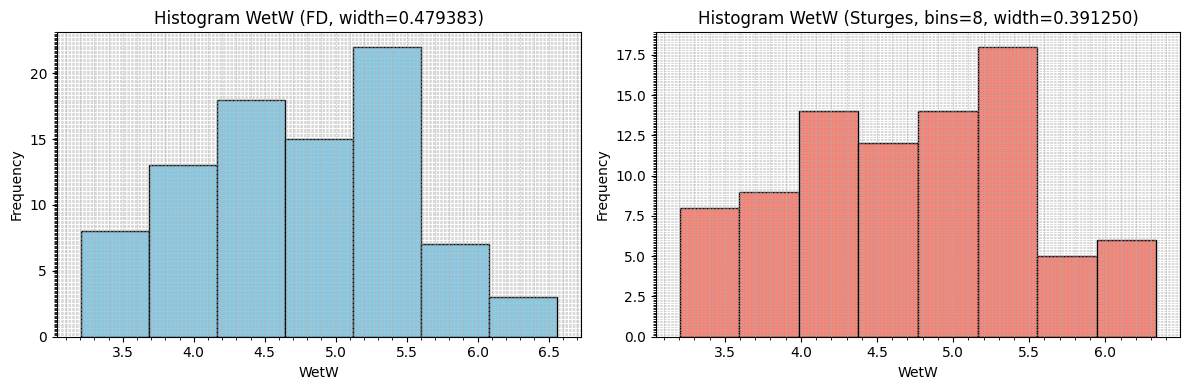


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,3.204000,3.683383,8
1,3.683383,4.162766,13
2,4.162766,4.642150,18
3,4.642150,5.121533,15
4,5.121533,5.600916,22
5,5.600916,6.080299,7
6,6.080299,6.559683,3



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,3.20400,3.59525,8
1,3.59525,3.98650,9
2,3.98650,4.37775,14
3,4.37775,4.76900,12
4,4.76900,5.16025,14
5,5.16025,5.55150,18
6,5.55150,5.94275,5
7,5.94275,6.33400,6


In [74]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def analyze_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns:
        print("Kolom 'WetW' tidak ada di dataframe.")
        return

    data = df_recovery['WetW'].dropna()
    if data.empty:
        print("Tidak ada data 'WetW' yang valid setelah drop NaN.")
        return

    # --- hitung jumlah bins ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram WetW (FD, width={width_fd_str})")
    axes[0].set_xlabel("WetW")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram WetW (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("WetW")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
wetw_data = analyze_wetw(df_recovery)

In [75]:
import numpy as np
from IPython.display import display

def filter_wetw_normal(df_recovery, lower_bound, upper_bound):
    """
    Filter data WetW berdasarkan batas bawah/atas,
    sekaligus memastikan hanya baris dengan Outlier_Status = 'Normal' yang lolos.
    Setelah selesai, kolom Outlier_Status dihapus.
    """
    # --- Filter berdasarkan WetW ---
    df_wetw = df_recovery[(df_recovery['WetW'] >= lower_bound) &
                          (df_recovery['WetW'] <= upper_bound)].copy()

    # --- Pastikan hanya baris Normal yang lolos ---
    if 'Outlier_Status' in df_wetw.columns:
        df_wetw = df_wetw[df_wetw['Outlier_Status'] == "Normal"].copy()
        # Drop kolom Outlier_Status setelah selesai
        df_wetw = df_wetw.drop(columns=['Outlier_Status'])
    else:
        print("Kolom Outlier_Status tidak ditemukan, hanya filter WetW yang diterapkan.")

    print(f"\nFiltered rows (Normal only): {len(df_wetw)}")
    display(df_wetw.head(10))

    return df_wetw

# --- Contoh pemanggilan ---
lower_bound = float(input("Masukkan batas bawah (>=): "))
upper_bound = float(input("Masukkan batas atas (<=): "))

df_wetw = filter_wetw_normal(df_recovery, lower_bound, upper_bound)

Masukkan batas bawah (>=): 3.98650
Masukkan batas atas (<=): 5.55150

Filtered rows (Normal only): 58


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
23,CS7210246,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,5.220,26.628,3.830,Rlim,None,LIM,LIMX,1.785444,1.310010,5.220,4.722365
59,CS6210193,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,5.251,17.882,4.312,Rlim,None,LIM,LIMX,1.796047,1.474872,5.251,4.722365
89,CS6210152R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,4.775,22.869,3.683,Rlim,None,LIM,LIMX,1.633236,1.259730,4.775,4.722365
150,CD02509,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.0,1.0,1.0,4.055,14.681,3.460,BS_1,None,LIM,LIMX,1.386968,1.183341,4.055,4.722365
260,CS6210139,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,4.754,15.145,4.034,Rlim,None,LIM,LIMX,1.626054,1.379785,4.754,4.722365
306,CS6210192,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,4.764,19.605,3.830,Rlim,None,LIM,LIMX,1.629474,1.310010,4.764,4.722365
778,CS7210095,Bintangor Blok 2 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,4.066,23.119,3.126,Rlim,None,LIM,LIMX,1.390731,1.069214,4.066,4.722365
1078,CS7210094,Bintangor Blok 2 Spasi 50,BINTANGOR,1.0,2.0,1.0,1.0,4.116,26.045,3.044,YLIM,None,LIM,LIMX,1.407833,1.041167,4.116,4.722365
1102,CD500140,BINTANGOR BARAT SELATAN,BINTANGOR,1.0,2.0,1.0,1.0,5.280,25.909,3.912,RLIM,None,LIM,LIMX,1.805966,1.338057,5.280,4.722365
1144,CS6210190,Bintangor Blok 2 Spasi 25,BINTANGOR,1.0,2.0,1.0,1.0,5.375,19.386,4.333,Rlim,None,LIM,LIMX,1.838460,1.482055,5.375,4.722365


#Filter By MC


Descriptive statistics for H2O:
Count: 58
Mean: 27.878724
Standard Error: 0.954722
Median: 27.9645
Mode: 6.305
Standard Deviation: 7.270944
Sample Variance: 52.866632
Kurtosis: 0.304693
Skewness: -0.520588
Range: 36.728
Minimum: 6.305
Maximum: 43.033
Sum: 1616.9660000000001
Confidence Level (95%): ±1.911797

Bin calculation:
Freedman–Diaconis -> bins=7, width=5.354601
Sturges -> bins=7, width=5.246857


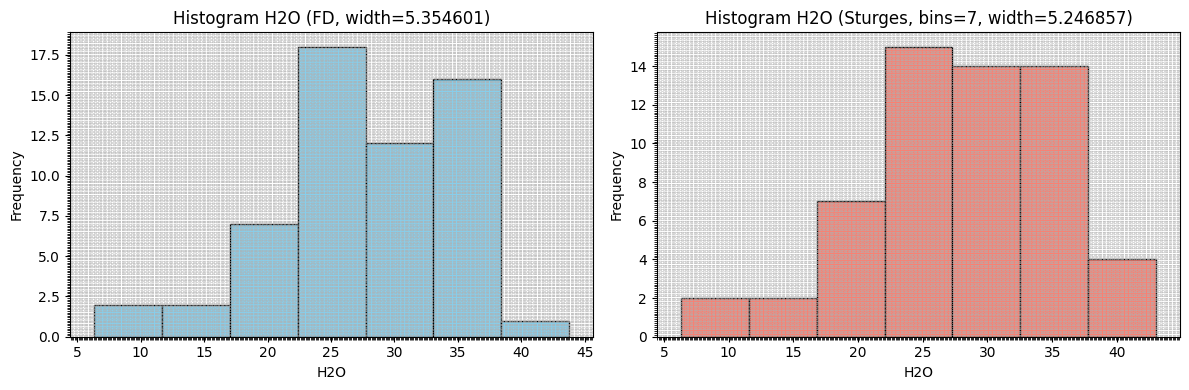


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,6.305000,11.659601,2
1,11.659601,17.014202,2
2,17.014202,22.368803,7
3,22.368803,27.723404,18
4,27.723404,33.078005,12
5,33.078005,38.432606,16
6,38.432606,43.787207,1



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,6.305000,11.551857,2
1,11.551857,16.798714,2
2,16.798714,22.045571,7
3,22.045571,27.292429,15
4,27.292429,32.539286,14
5,32.539286,37.786143,14
6,37.786143,43.033000,4


In [76]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="H2O"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_h2o(df_wetw):
    if 'H2O' not in df_wetw.columns:
        print("Kolom 'H2O' tidak ada di dataframe.")
        return

    data = df_wetw['H2O'].dropna()
    if data.empty:
        print("Tidak ada data 'H2O' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="H2O")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram H2O (FD, width={width_fd_str})")
    axes[0].set_xlabel("H2O")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram H2O (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("H2O")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
h2o_data = analyze_h2o(df_wetw)

In [77]:

import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_wetw berdasarkan H2O
df_h2o = df_wetw[(df_wetw['H2O'] >= lower_bound) &
                 (df_wetw['H2O'] <= upper_bound)].copy()

print(f"\nFiltered rows (H2O): {len(df_h2o)}")
display(df_h2o.head(10))

is greater than or equal to: 22.045571
is less than or equal to: 37.786143

Filtered rows (H2O): 43


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
23,CS7210246,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,5.220,26.628,3.830,Rlim,None,LIM,LIMX,1.785444,1.310010,5.220,4.722365
89,CS6210152R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,4.775,22.869,3.683,Rlim,None,LIM,LIMX,1.633236,1.259730,4.775,4.722365
778,CS7210095,Bintangor Blok 2 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,4.066,23.119,3.126,Rlim,None,LIM,LIMX,1.390731,1.069214,4.066,4.722365
1078,CS7210094,Bintangor Blok 2 Spasi 50,BINTANGOR,1.0,2.0,1.0,1.0,4.116,26.045,3.044,YLIM,None,LIM,LIMX,1.407833,1.041167,4.116,4.722365
1102,CD500140,BINTANGOR BARAT SELATAN,BINTANGOR,1.0,2.0,1.0,1.0,5.280,25.909,3.912,RLIM,None,LIM,LIMX,1.805966,1.338057,5.280,4.722365
1215,CS7210246,Bintangor Blok 1 Spasi 50,BINTANGOR,1.0,2.0,1.0,1.0,4.240,29.009,3.010,Rlim,None,LIM,LIMX,1.450246,1.029538,4.240,4.722365
1241,CS6210192,Bintangor Blok 2 Spasi 25,BINTANGOR,1.0,2.0,1.0,1.0,4.792,23.664,3.658,Rlim,None,LIM,LIMX,1.639051,1.251179,4.792,4.722365
1321,CS7210085,Bintangor Blok 2 Spasi 50,BINTANGOR,1.0,2.0,1.0,1.0,4.466,31.438,3.062,YLIM,None,LIM,LIMX,1.527546,1.047324,4.466,4.722365
1634,CS6210031,Bintangor Blok 2 Spasi 25,BINTANGOR,1.0,2.0,1.0,1.0,5.362,25.103,4.016,Rlim,None,LIM,LIMX,1.834013,1.373629,5.362,4.722365
1982,CS6210030,Bintangor Blok 2 Spasi 25,BINTANGOR,2.0,3.0,1.0,1.0,5.140,26.148,3.796,Rlim,None,LIM,LIMX,1.758081,1.298380,5.140,4.722365


# Filter By DTF


Descriptive statistics for DTF:
Count: 43
Mean: 1.154051
Standard Error: 0.022459
Median: 1.12736068
Mode: 0.898194522
Standard Deviation: 0.147271
Sample Variance: 0.021689
Kurtosis: -1.157720
Skewness: 0.292619
Range: 0.5096381720000001
Minimum: 0.898194522
Maximum: 1.407832694
Sum: 49.62420753999999
Confidence Level (95%): ±0.045323

Bin calculation:
Freedman–Diaconis -> bins=5, width=0.129165
Sturges -> bins=7, width=0.072805


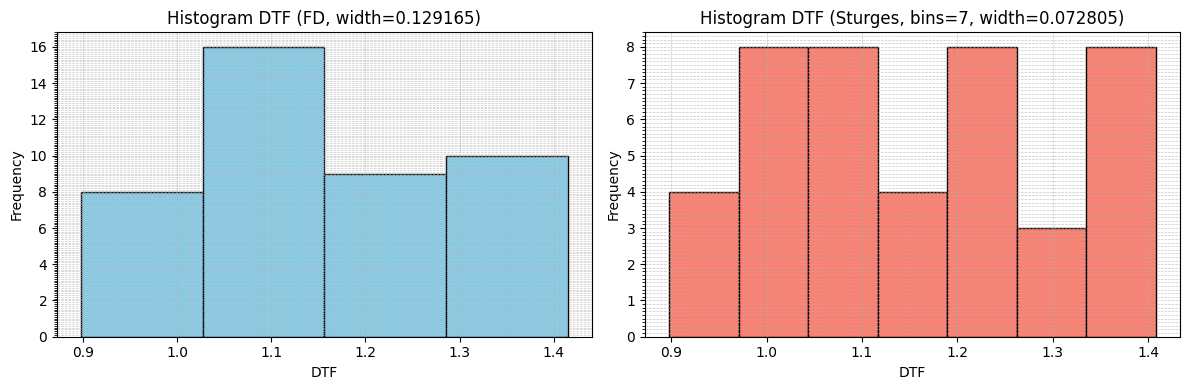


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.898195,1.027360,8
1,1.027360,1.156525,16
2,1.156525,1.285691,9
3,1.285691,1.414856,10



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.898195,0.971000,4
1,0.971000,1.043805,8
2,1.043805,1.116611,8
3,1.116611,1.189416,4
4,1.189416,1.262222,8
5,1.262222,1.335027,3
6,1.335027,1.407833,8


In [78]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="DTF"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_dtf(df_h2o):
    if 'DTF' not in df_h2o.columns:
        print("Kolom 'DTF' tidak ada di dataframe.")
        return

    data = df_h2o['DTF'].dropna()
    if data.empty:
        print("Tidak ada data 'DTF' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="DTF")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram DTF (FD, width={width_fd_str})")
    axes[0].set_xlabel("DTF")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram DTF (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("DTF")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
dtf_data = analyze_dtf(df_h2o)

In [82]:
import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_h2o berdasarkan DTF
df_dtf = df_h2o[(df_h2o['DTF'] >= lower_bound) &
                (df_h2o['DTF'] <= upper_bound)].copy()

print(f"\nFiltered rows (DTF): {len(df_dtf)}")
display(df_dtf.head(89))

is greater than or equal to: 1.027360
is less than or equal to: 1.414856

Filtered rows (DTF): 35


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
23,CS7210246,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,5.220,26.628,3.830,Rlim,None,LIM,LIMX,1.785444,1.310010,5.220,4.722365
89,CS6210152R,Bintangor Blok 2 Spasi 25,BINTANGOR,0.0,1.0,1.0,1.0,4.775,22.869,3.683,Rlim,None,LIM,LIMX,1.633236,1.259730,4.775,4.722365
778,CS7210095,Bintangor Blok 2 Spasi 50,BINTANGOR,0.0,1.0,1.0,1.0,4.066,23.119,3.126,Rlim,None,LIM,LIMX,1.390731,1.069214,4.066,4.722365
1078,CS7210094,Bintangor Blok 2 Spasi 50,BINTANGOR,1.0,2.0,1.0,1.0,4.116,26.045,3.044,YLIM,None,LIM,LIMX,1.407833,1.041167,4.116,4.722365
1102,CD500140,BINTANGOR BARAT SELATAN,BINTANGOR,1.0,2.0,1.0,1.0,5.280,25.909,3.912,RLIM,None,LIM,LIMX,1.805966,1.338057,5.280,4.722365
1215,CS7210246,Bintangor Blok 1 Spasi 50,BINTANGOR,1.0,2.0,1.0,1.0,4.240,29.009,3.010,Rlim,None,LIM,LIMX,1.450246,1.029538,4.240,4.722365
1241,CS6210192,Bintangor Blok 2 Spasi 25,BINTANGOR,1.0,2.0,1.0,1.0,4.792,23.664,3.658,Rlim,None,LIM,LIMX,1.639051,1.251179,4.792,4.722365
1321,CS7210085,Bintangor Blok 2 Spasi 50,BINTANGOR,1.0,2.0,1.0,1.0,4.466,31.438,3.062,YLIM,None,LIM,LIMX,1.527546,1.047324,4.466,4.722365
1634,CS6210031,Bintangor Blok 2 Spasi 25,BINTANGOR,1.0,2.0,1.0,1.0,5.362,25.103,4.016,Rlim,None,LIM,LIMX,1.834013,1.373629,5.362,4.722365
1982,CS6210030,Bintangor Blok 2 Spasi 25,BINTANGOR,2.0,3.0,1.0,1.0,5.140,26.148,3.796,Rlim,None,LIM,LIMX,1.758081,1.298380,5.140,4.722365


# SUMMARY

In [83]:
import numpy as np
import scipy.stats as stats

def descriptive_stats(series, label):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

# --- Jalankan untuk semua kolom yang diminta ---
target_columns = ["Interval", "CoreRec", "WetW", "H2O", "DryW", "WTF", "DTF"]

for col in target_columns:
    if col in df_dtf.columns:
        descriptive_stats(df_dtf[col], label=col)
    else:
        print(f"\nKolom {col} tidak ditemukan di df_dtf.")


Descriptive statistics for Interval:
Count: 35
Mean: 1.000000
Standard Error: 0.000000
Median: 1.0
Mode: 1.0
Standard Deviation: 0.000000
Sample Variance: 0.000000
Kurtosis: N/A
Skewness: N/A
Range: 0.0
Minimum: 1.0
Maximum: 1.0
Sum: 35.0
Confidence Level (95%): ±0.000000

Descriptive statistics for CoreRec:
Count: 35
Mean: 1.000000
Standard Error: 0.000000
Median: 1.0
Mode: 1.0
Standard Deviation: 0.000000
Sample Variance: 0.000000
Kurtosis: N/A
Skewness: N/A
Range: 0.0
Minimum: 1.0
Maximum: 1.0
Sum: 35.0
Confidence Level (95%): ±0.000000

Descriptive statistics for WetW:
Count: 35
Mean: 4.882343
Standard Error: 0.071779
Median: 4.883
Mode: 4.792
Standard Deviation: 0.424653
Sample Variance: 0.180330
Kurtosis: -1.099566
Skewness: -0.310411
Range: 1.4249999999999998
Minimum: 4.066
Maximum: 5.491
Sum: 170.882
Confidence Level (95%): ±0.145873

Descriptive statistics for H2O:
Count: 35
Mean: 28.457914
Standard Error: 0.683453
Median: 27.523
Mode: 22.727
Standard Deviation: 4.043362
Samp

/tmp/ipython-input-1308544473.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = stats.kurtosis(data) if n > 3 else np.nan
/tmp/ipython-input-1308544473.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(data) if n > 2 else np.nan


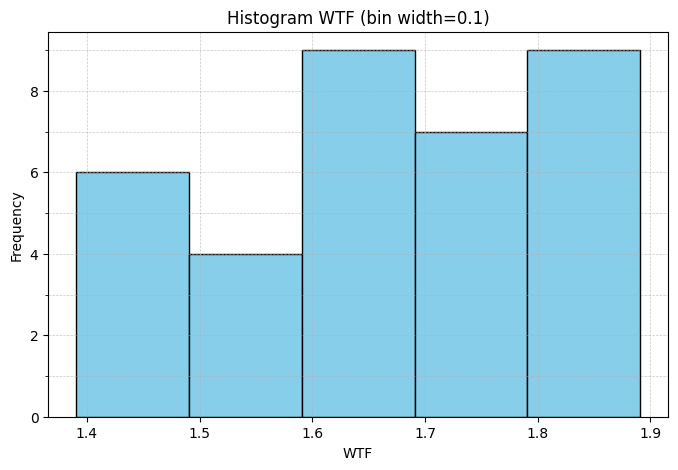


Tabel Histogram WTF:


,Bin Start,Bin End,Frequency
0,1.390731,1.490731,6
1,1.490731,1.590731,4
2,1.590731,1.690731,9
3,1.690731,1.790731,7
4,1.790731,1.890731,9


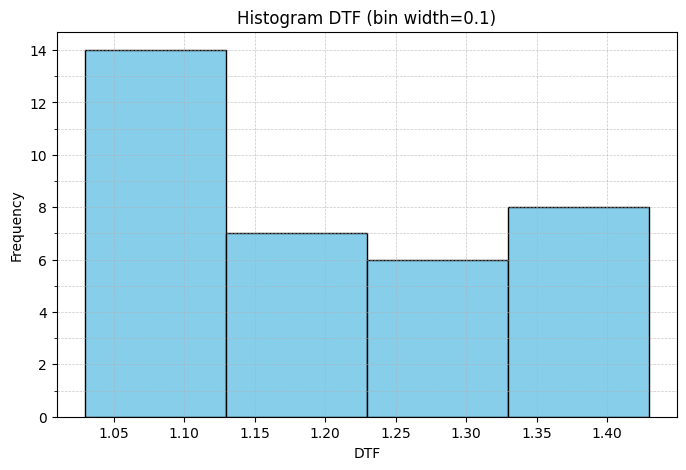


Tabel Histogram DTF:


,Bin Start,Bin End,Frequency
0,1.029538,1.129538,14
1,1.129538,1.229538,7
2,1.229538,1.329538,6
3,1.329538,1.429538,8


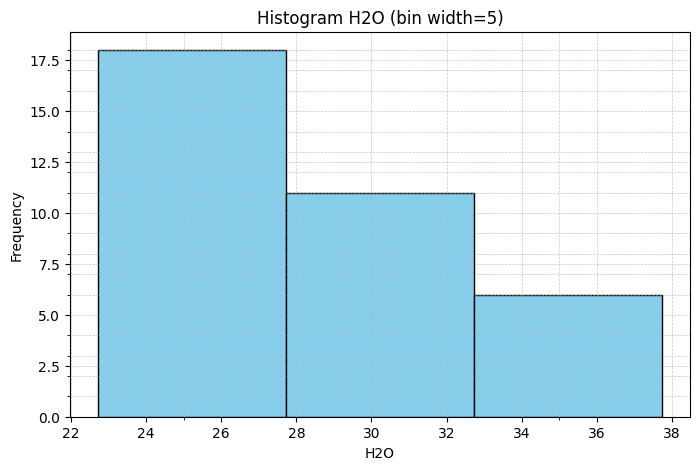


Tabel Histogram H2O:


,Bin Start,Bin End,Frequency
0,22.727,27.727,18
1,27.727,32.727,11
2,32.727,37.727,6


In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator

def plot_histogram_fixed_width(series, bin_width, label):
    data = series.dropna().values
    if len(data) == 0:
        print(f"Tidak ada data untuk {label}.")
        return None

    # Tentukan bins berdasarkan bin_width
    min_val, max_val = data.min(), data.max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Plot histogram
    plt.figure(figsize=(8,5))
    counts, edges, _ = plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"Histogram {label} (bin width={bin_width})")
    plt.xlabel(label)
    plt.ylabel("Frequency")

    # Minor ticks sesuai bin width
    plt.gca().xaxis.set_minor_locator(MultipleLocator(bin_width))
    plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    # Buat tabel histogram
    table = pd.DataFrame({
        "Bin Start": edges[:-1],
        "Bin End": edges[1:],
        "Frequency": counts.astype(int)
    })

    print(f"\nTabel Histogram {label}:")
    display(table)
    return table

# --- Contoh pemanggilan ---
table_wtf = plot_histogram_fixed_width(df_dtf['WTF'], bin_width=0.1, label="WTF")
table_dtf = plot_histogram_fixed_width(df_dtf['DTF'], bin_width=0.1, label="DTF")
table_h2o = plot_histogram_fixed_width(df_dtf['H2O'], bin_width=5, label="H2O")

In [86]:
import pandas as pd

# Input nama Block, GEN_LYR, dan Material
block_name = input("Masukkan nama Block: ")
gen_lyr = input("Masukkan GEN_LYR: ")

# Hitung nilai ringkasan (contoh: mean)
summary = {
    "Block": block_name,
    "GEN_LYR": gen_lyr,
    "Interval_mean": df_dtf['Interval'].dropna().mean(),
    "CoreRec_mean": df_dtf['CoreRec'].dropna().mean(),
    "WetW_mean": df_dtf['WetW'].dropna().mean(),
    "H2O_mean": df_dtf['H2O'].dropna().mean(),
    "DryW_mean": df_dtf['DryW'].dropna().mean(),
    "WTF_mean": df_dtf['WTF'].dropna().mean(),
    "DTF_mean": df_dtf['DTF'].dropna().mean()
}

# Buat nama variabel DataFrame sesuai input
var_name = f"df_{block_name.replace(' ', '_').lower()}_{gen_lyr.lower()}"
globals()[var_name] = pd.DataFrame([summary])

print(f"\nTabel Ringkasan tersimpan sebagai variabel: {var_name}")
display(globals()[var_name])

Masukkan nama Block: Bintangor
Masukkan GEN_LYR: LIMX

Tabel Ringkasan tersimpan sebagai variabel: df_bintangor_limx


,Block,GEN_LYR,Interval_mean,CoreRec_mean,WetW_mean,H2O_mean,DryW_mean,WTF_mean,DTF_mean
0,Bintangor,LIMX,1.0,1.0,4.882343,28.457914,3.494371,1.669952,1.195218
